# Random Forest Regression

In [41]:
import pathlib

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

## Read Data

In [42]:
data_dir: pathlib.Path = pathlib.Path.cwd() / "datasets" / "processed"

In [43]:
train_df: pd.DataFrame = pd.read_parquet(data_dir / "train.parquet")
val_df: pd.DataFrame = pd.read_parquet(data_dir / "val.parquet")

## Debugging & development

Uncomment this for faster computations.

In [44]:
train_df = train_df.sample(frac=0.1, random_state=0)
val_df = val_df.sample(frac=0.1, random_state=0)

## Separate dependant and independant variables

In [45]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11558635 entries, 90502816 to 25166257
Data columns (total 22 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   Airline            int64 
 1   Origin             int64 
 2   Year               uint16
 3   Distance           uint16
 4   Cancelled          bool  
 5   DestState          int64 
 6   ActualElapsedTime  int16 
 7   OriginState        int64 
 8   ArrTime            uint16
 9   DestCityName       int64 
 10  CRSElapsedTime     int16 
 11  DepTime            uint16
 12  DepDelay           uint16
 13  Diverted           bool  
 14  CRSArrTime         uint16
 15  DayOfWeek          uint8 
 16  OriginCityName     int64 
 17  ArrDelay           uint16
 18  Dest               int64 
 19  Month              uint8 
 20  CRSDepTime         uint16
 21  DayofMonth         uint8 
dtypes: bool(2), int16(2), int64(7), uint16(8), uint8(3)
memory usage: 981.1 MB


In [46]:
# x_train, y_train = train_df.drop(['ActualElapsedTime', 'ArrTime', 'DepTime', 'DepDelay', 'ArrDelay', 'Cancelled', 'Diverted'], axis=1), train_df['ArrDelay']
# x_val, y_val = val_df.drop(['ActualElapsedTime', 'ArrTime', 'DepTime', 'DepDelay', 'ArrDelay', 'Cancelled', 'Diverted'], axis=1), val_df['ArrDelay']

x_train, y_train = train_df.drop(['ActualElapsedTime', 'ArrTime', 'ArrDelay', 'Cancelled', 'Diverted'], axis=1), train_df['ArrDelay']
x_val, y_val = val_df.drop(['ActualElapsedTime', 'ArrTime', 'ArrDelay', 'Cancelled', 'Diverted'], axis=1), val_df['ArrDelay']

<Axes: >

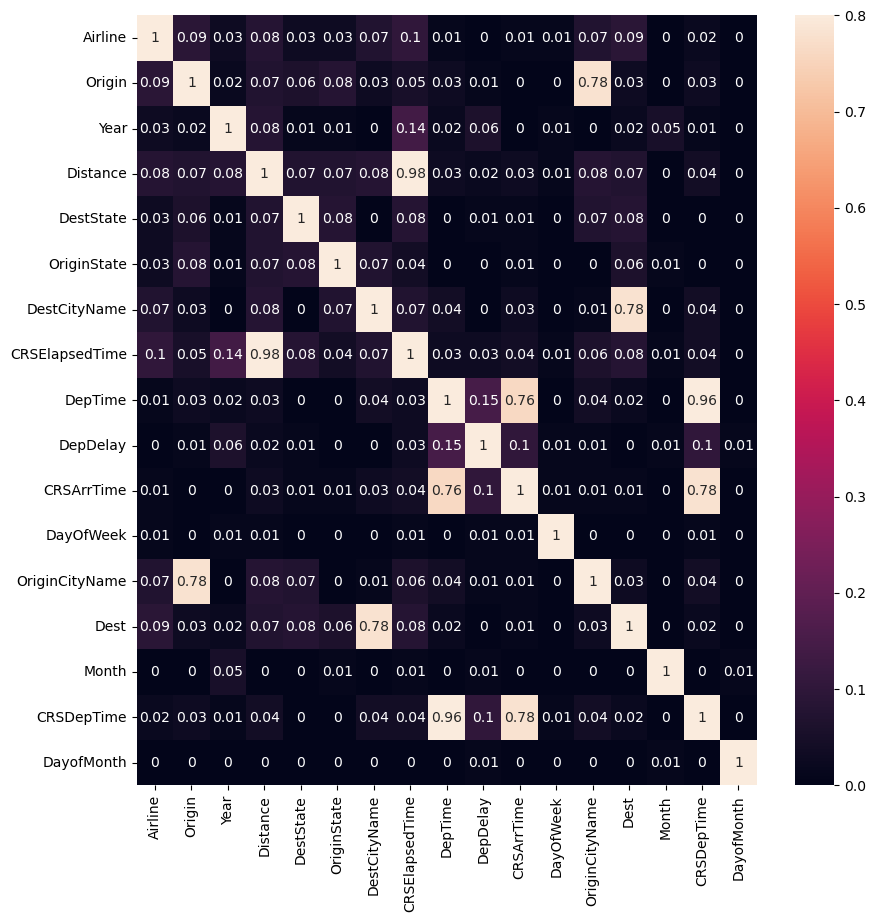

In [47]:
plt.figure(figsize=(10, 10))
sns.heatmap(x_train.corr().round(2).abs(), annot=True, vmax=0.8)

In [48]:
x_train.var()

Airline              224.493042
Origin             12947.074349
Year                 103.375374
Distance          312288.181227
DestState            250.575852
OriginState          250.673791
DestCityName       15606.396561
CRSElapsedTime      4766.689133
DepTime           230893.072850
DepDelay            1013.019802
CRSArrTime        245966.884053
DayOfWeek              3.973578
OriginCityName     15722.820356
Dest               12816.734741
Month                 11.941773
CRSDepTime        228086.761146
DayofMonth            77.204553
dtype: float64

In [49]:
x_train.drop(['Origin', 'CRSElapsedTime', 'Dest', 'CRSDepTime'], axis=1, inplace=True)
x_val.drop(['Origin', 'CRSElapsedTime', 'Dest', 'CRSDepTime'], axis=1, inplace=True)

<Axes: >

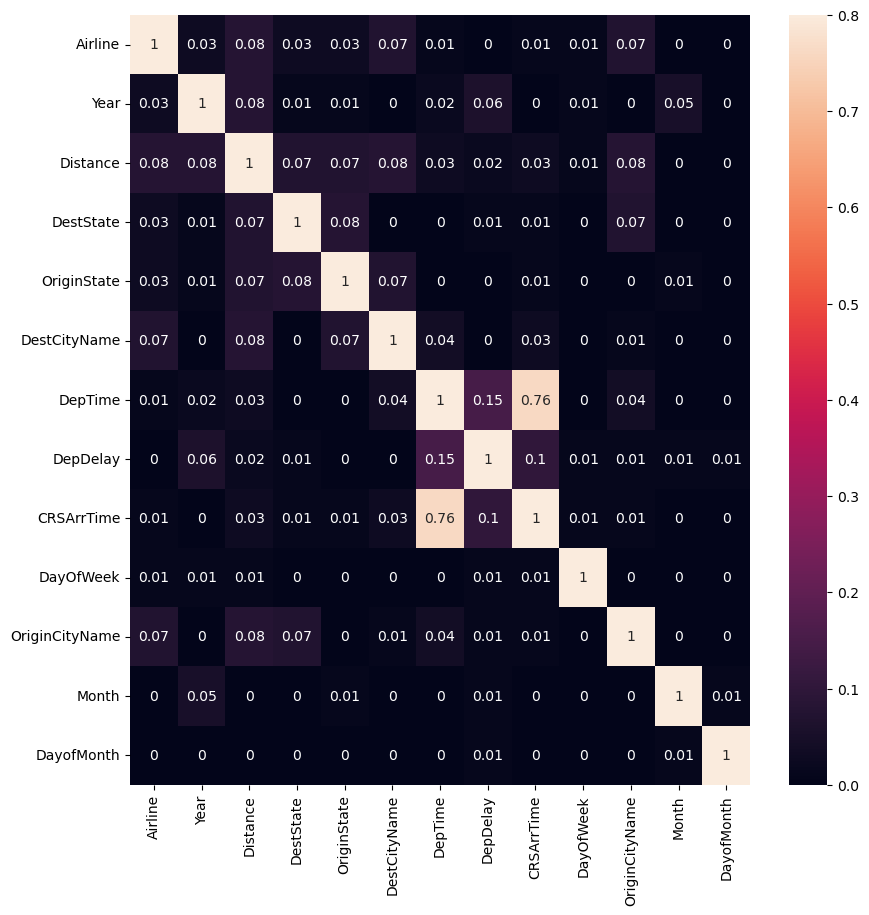

In [50]:
plt.figure(figsize=(10, 10))
sns.heatmap(x_train.corr().round(2).abs(), annot=True, vmax=0.8)

From the highly correlated features we drop the ones with the lowest variance.

## Fit forest

In [66]:
forest_regressor: RandomForestRegressor = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, criterion='squared_error', max_depth=3)

In [67]:
forest_regressor.fit(x_train, y_train)

RandomForestRegressor(max_depth=3, n_jobs=-1, random_state=42)

Save the regressor for further use during deployment.

In [75]:
from pickle import dump

dump(forest_regressor, open('models/random_forest_regressor.pkl', 'wb'))

## Visualize forest

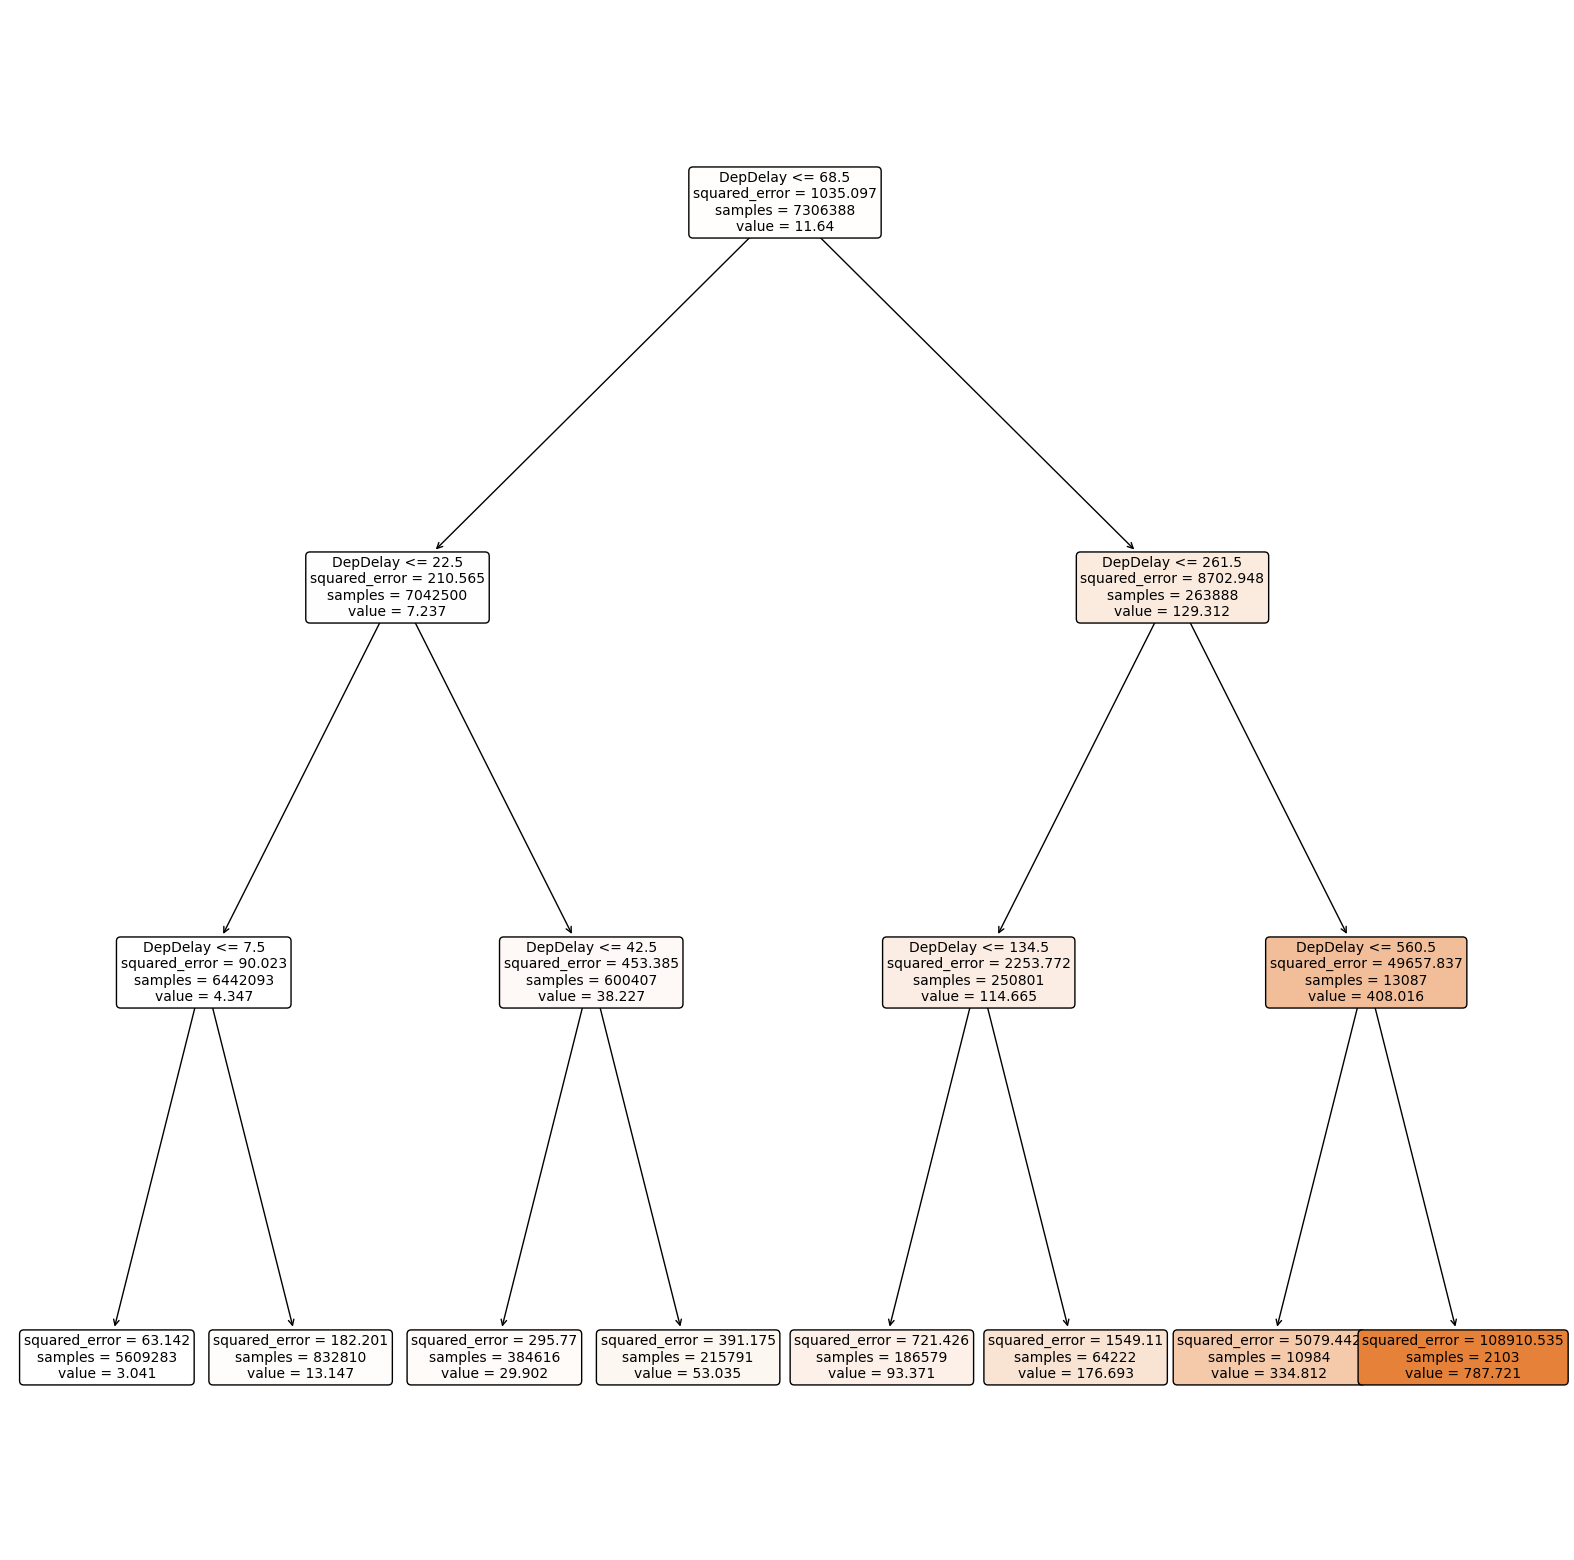

In [76]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 20))
plot_tree(forest_regressor.estimators_[0], feature_names=x_train.columns, filled=True, rounded=True, fontsize=10)
plt.savefig('figures/tree.png')

## Evaluate on cross-validation data

In [53]:
pred_val = forest_regressor.predict(x_val)

In [54]:
# x_val_pred
y_val.reset_index(drop=True, inplace=True)
# y_val

eval_val: pd.DataFrame = pd.DataFrame([pred_val, y_val]).T
eval_val.columns = ['Predicted', 'Actual']

eval_val['Squarred Error'] = (eval_val['Predicted'] - eval_val['Actual'])**2
eval_val['Absolute Error'] = (eval_val['Predicted'] - eval_val['Actual']).abs()
mse = eval_val['Squarred Error'].mean()
mae = eval_val['Absolute Error'].mean()

mse, mae

(111.37300159678111, 5.622571666664576)

# NN

In [55]:
x_train = x_train.drop(['DestState', 'OriginState', 'DestCityName', 'OriginCityName'], axis=1)
x_val = x_val.drop(['DestState', 'OriginState', 'DestCityName', 'OriginCityName'], axis=1)

In [56]:
import tensorflow as tf

# tf.config.set_visible_devices([], 'GPU')

In [57]:
model = tf.keras.Sequential([
    tf.keras.layers.Normalization(input_shape=[len(x_train.columns)]),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])


In [58]:
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), metrics=['mean_absolute_error', 'mean_squared_error'])

In [59]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 9)                19        
 ion)                                                            
                                                                 
 dense_15 (Dense)            (None, 16)                160       
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_16 (Dense)            (None, 16)                272       
                                                                 
 dropout_8 (Dropout)         (None, 16)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                      

In [60]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), batch_size=20480)

Epoch 1/100


2023-03-20 07:39:12.324594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


565/565 [==============================] - ETA: 0s - loss: 4704.5874 - mean_absolute_error: 22.0716 - mean_squared_error: 4704.5874

2023-03-20 07:39:18.594139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


565/565 [==============================] - 7s 11ms/step - loss: 4704.5874 - mean_absolute_error: 22.0716 - mean_squared_error: 4704.5874 - val_loss: 293.2320 - val_mean_absolute_error: 7.8925 - val_mean_squared_error: 293.2320
Epoch 2/100
565/565 [==============================] - 6s 10ms/step - loss: 329.5018 - mean_absolute_error: 7.9514 - mean_squared_error: 329.5018 - val_loss: 246.6161 - val_mean_absolute_error: 6.2886 - val_mean_squared_error: 246.6161
Epoch 3/100
565/565 [==============================] - 5s 10ms/step - loss: 270.5905 - mean_absolute_error: 7.3899 - mean_squared_error: 270.5905 - val_loss: 241.0458 - val_mean_absolute_error: 6.4635 - val_mean_squared_error: 241.0458
Epoch 4/100
565/565 [==============================] - 6s 10ms/step - loss: 248.8801 - mean_absolute_error: 7.2679 - mean_squared_error: 248.8801 - val_loss: 255.5142 - val_mean_absolute_error: 6.8268 - val_mean_squared_error: 255.5142
Epoch 5/100
565/565 [==============================] - 6s 10ms/st

KeyboardInterrupt: 

In [ ]:
model.predict(x_val)

  78/4516 [..............................] - ETA: 8s

2023-03-17 15:56:17.103517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4516/4516 [==============================] - 8s 2ms/step


array([[ 2.9874363],
       [10.683429 ],
       [ 9.396067 ],
       ...,
       [ 2.9874363],
       [ 7.153034 ],
       [ 2.9874363]], dtype=float32)

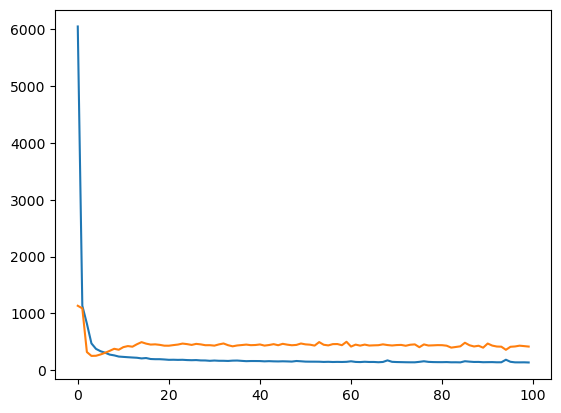

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])